#Jenkins Time Series Analysis

## Data Preprocessing


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [33]:
import pandas as pd
import re

def clean_timestamp(ts):
    """ Remove ordinal indicators from timestamp strings only when they follow a number """
    return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', ts)

def load_and_preprocess(file_name, timestamp_col, rename_dict, time_format):
    """ Load and preprocess a CSV file """
    df = pd.read_csv(file_name)
    print(f"Columns in {file_name}: {df.columns}")
    df = df.rename(columns=rename_dict)
    df['timestamp'] = df[timestamp_col].apply(clean_timestamp)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=time_format)
    return df

# Load daily logs
daily_files = [f'daily_log{i}.csv' for i in range(1, 5)]
daily_rename_dict = {
    '@timestamp per day': 'timestamp',
    'buildDefinitionId.keyword: Descending': 'pipeline_id',
    'Count': 'count'
}
daily_data = [load_and_preprocess(file, 'timestamp', daily_rename_dict, '%B %d %Y, %H:%M:%S.%f') for file in daily_files]

# Load weekly logs
weekly_files = [f'weekly_log{i}.csv' for i in range(1, 3)]
weekly_rename_dict = {
    '@timestamp per week': 'timestamp',
    'usageMetrics.exec_id.keyword: Descending': 'pipeline_id',
    'Count': 'count',
    'Last usageMetrics.available_cpu_cores': 'available_cpu_cores',
    'Last usageMetrics.guaranteed_cpu_cores': 'guaranteed_cpu_cores',
    'Last usageMetrics.used_cpu_cores': 'used_cpu_cores',
    'Last usageMetrics.max_cpu_cores': 'max_cpu_cores'
}
weekly_data = [load_and_preprocess(file, 'timestamp', weekly_rename_dict, '%B %d %Y, %H:%M:%S.%f') for file in weekly_files]

# Combine all daily data
daily_combined = pd.concat(daily_data, ignore_index=True)

# Combine all weekly data
weekly_combined = pd.concat(weekly_data, ignore_index=True)

# If needed, save combined data to a CSV file
daily_combined.to_csv('daily_combined_data.csv', index=False)
weekly_combined.to_csv('weekly_combined_data.csv', index=False)

print("Daily Data:")
print(daily_combined.head())

print("Weekly Data:")
print(weekly_combined.head())

Columns in daily_log1.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in daily_log2.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in daily_log3.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in daily_log4.csv: Index(['@timestamp per day', 'buildDefinitionId.keyword: Descending', 'Count'], dtype='object')
Columns in weekly_log1.csv: Index(['@timestamp per week', 'usageMetrics.exec_id.keyword: Descending',
       'Count', 'Last usageMetrics.available_cpu_cores',
       'Last usageMetrics.guaranteed_cpu_cores',
       'Last usageMetrics.used_cpu_cores', 'Last usageMetrics.max_cpu_cores'],
      dtype='object')
Columns in weekly_log2.csv: Index(['@timestamp per week', 'usageMetrics.exec_id.keyword: Descending',
       'Count', 'Last usageMetrics.available_cpu_cores',
       'Last usageMetrics.guaranteed_cpu

## ARIMA Model

ADF Statistic: -3.0812623949474442
p-value: 0.02797129103280463
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  736
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6829.261
Date:                Fri, 31 May 2024   AIC                          13664.523
Time:                        10:05:11   BIC                          13678.322
Sample:                    12-27-2021   HQIC                         13669.845
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1565      0.374     -0.418      0.676      -0.890       0.577
ma.L1         -1.0000      0.119     -8.399      0.000      -1.233 

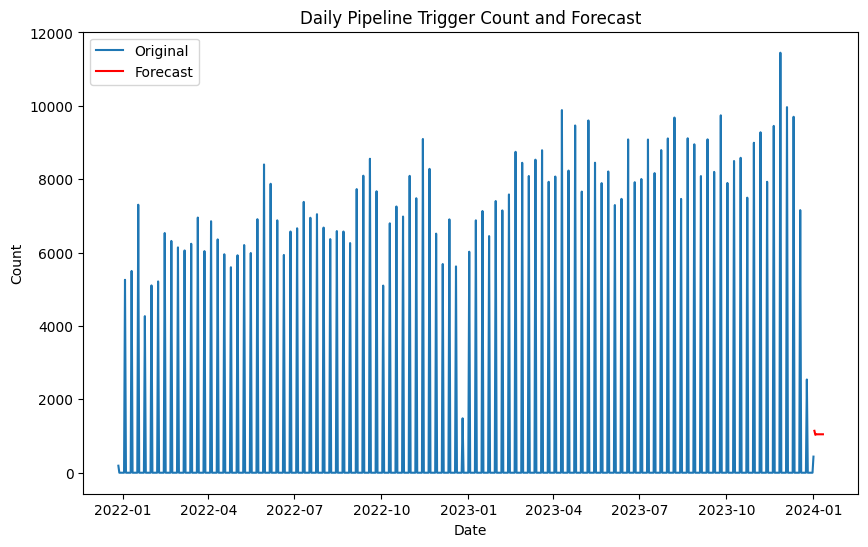

In [35]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Extract and aggregate daily data by timestamp
daily_ts = daily_combined.groupby('timestamp')['count'].sum().asfreq('D')

# Check for missing values and impute if necessary
daily_ts = daily_ts.fillna(0)

# Check for stationarity
result = adfuller(daily_ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Differencing if needed
if result[1] > 0.05:  # Non-stationary
    daily_ts_diff = daily_ts.diff().dropna()
else:
    daily_ts_diff = daily_ts

# Fit ARIMA model
model = ARIMA(daily_ts_diff, order=(1, 1, 1))  # Adjust the order (p, d, q) as needed
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=10)  # Forecast next 10 periods
print(forecast)

# Plot the original series and forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_ts, label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Daily Pipeline Trigger Count and Forecast')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()
